In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

In [3]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


In [4]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

In [5]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [69]:
def calcular_p_retraso(serie_sintomas, serie_confirmacion):
    
    # serie_sintomas = "../../datos/datos_abiertos/serie_tiempo_nacional_confirmados.csv"
    # serie_confirmacion = "../../datos/datos_abiertos/serie_tiempo_nacional_fecha_confirmacion.csv"
    
    # Leer tablas
    Dat_sintomas = pd.read_csv(serie_sintomas)
    Dat_sintomas.head()
    Dat_confirmacion = pd.read_csv(serie_confirmacion)
    Dat_confirmacion.head()
    Dat_sintomas = Dat_sintomas[['fecha', 'sintomas_acumulados']]
    Dat_confirmacion = Dat_confirmacion[['fecha', 'casos_acumulados']]
    
    # Unir tablas
    Dat = pd.concat([Dat_sintomas.set_index('fecha'), Dat_confirmacion.set_index('fecha')], axis=1, sort=False).reset_index(col_fill = 'fecha')
    Dat.columns = ['fecha', 'sintomas_acumulados', 'casos_acumulados']
    Dat = Dat.fillna(0)
    # Dat['dif'] = Dat.sintomas_acumulados - Dat.casos_acumulados
    Dat.fecha = pd.to_datetime(Dat.fecha)
    # Dat
    
    # Preparar serie vacía
    dias = (pd.Series(max(Dat.fecha)) - pd.Series(min(Dat.fecha))).dt.days[0]
    p_retraso = pd.Series(np.zeros(dias))
    for i, fila in Dat.iterrows():
        for j in range(i, Dat.shape[0]):
            # print(i, j)
            if Dat.casos_acumulados[j] >= Dat.sintomas_acumulados[i]:
                # print("hola")
                # Sumar casos retrasados n dias
                p_retraso[j - i] = p_retraso[j - i] + abs(Dat.sintomas_acumulados[i] - Dat.casos_acumulados[j])
                break
    
    # Calcular prob
    # p_retraso.sum()
    p_retraso = p_retraso / p_retraso.sum()
    # print(p_retraso.to_string())
    
    # Limpiar
    ii = p_retraso > 0
    ii_max = np.max(p_retraso.index[ii])
    p_retraso = p_retraso[0:ii_max]

    return p_retraso

In [10]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

## SUR
states = {state: grp for state, grp in states.groupby('state')}['CA']
states.head()

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
CA    2020-03-04      53.0     462.0      NaN                    NaN   
      2020-03-05      53.0     462.0      NaN                    NaN   
      2020-03-06      60.0     462.0      NaN                    NaN   
      2020-03-07      69.0     462.0      NaN                    NaN   
      2020-03-08      88.0     462.0      NaN                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
CA    2020-03-04                     NaN             NaN              NaN   
      2020-03-05                     NaN             NaN              NaN   
      2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
CA    2020-03-04                    NaN                     NaN        NaN   
      2020-03-05                    NaN                     NaN        NaN   
      2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   

                  ... hospitalized  total  totalTestResults  posNeg  fips  \
state date        ...                                                       
CA    2020-03-04  ...          NaN  515.0             515.0   515.0     6   
      2020-03-05  ...          NaN  515.0             515.0   515.0     6   
      2020-03-06  ...          NaN  522.0             522.0   522.0     6   
      2020-03-07  ...          NaN  531.0             531.0   531.0     6   
      2020-03-08  ...          NaN  550.0             550.0   550.0     6   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
CA    2020-03-04            NaN                   NaN               NaN   
      2020-03-05            0.0                   0.0               0.0   
      2020-03-06            0.0                   0.0               0.0   
      2020-03-07            0.0                   0.0               0.0   
      2020-03-08            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
CA    2020-03-04               NaN                       NaN  
      2020-03-05               0.0                       0.0  
      2020-03-06               7.0                       7.0  
      2020-03-07               9.0                       9.0  
      2020-03-08              19.0                      19.0  

[5 rows x 23 columns]

In [11]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

In [12]:
# Load the patient CSV
patients = pd.read_csv(
    '../../COVID-20/data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

## SUR
patients.head()

,Onset,Confirmed
53,2020-02-08,2020-02-14
55,2020-02-01,2020-02-13
335,2020-01-30,2020-02-14
365,2020-02-14,2020-02-16
446,2020-02-11,2020-02-15


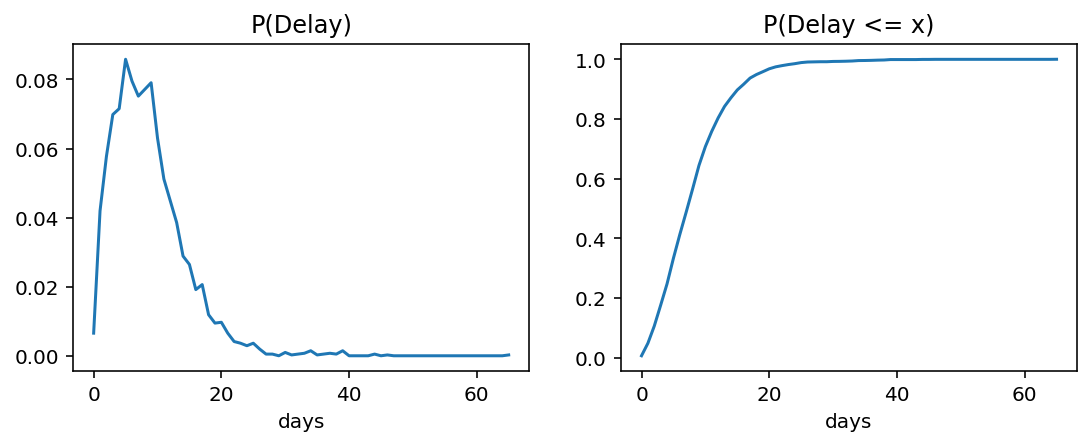

In [13]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [24]:
# SUR
# p_delay
print(p_delay.to_string())

0     0.006547
1     0.041950
2     0.057711
3     0.069835
4     0.071532
5     0.085839
6     0.079534
7     0.075170
8     0.077110
9     0.079049
10    0.063046
11    0.051164
12    0.044859
13    0.038555
14    0.028855
15    0.026431
16    0.019156
17    0.020611
18    0.011882
19    0.009457
20    0.009699
21    0.006547
22    0.004122
23    0.003637
24    0.002910
25    0.003637
26    0.001940
27    0.000485
28    0.000485
29    0.000000
30    0.000970
31    0.000242
32    0.000485
33    0.000727
34    0.001455
35    0.000242
36    0.000485
37    0.000727
38    0.000485
39    0.001455
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000485
45    0.000000
46    0.000242
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.000000
58    0.000000
59    0.000000
60    0.000000
61    0.000000
62    0.000000
63    0.000000
64    0.000000
65    0.000242


In [ ]:
# state = 'CA'
# confirmed = states.xs(state).positive.diff().dropna()
# onset = confirmed_to_onset(confirmed, p_delay)
# ## SUR
# onset.head()

In [ ]:
# adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

# ## SUR
# print(adjusted.head())
# cumulative_p_delay

In [ ]:
models = {}

for state, grp in states.groupby('state'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_rbun_model(state, grp.droplevel(0))

In [ ]:
name = 'CA'
confirmed = states.positive.diff().dropna()
# confirmed = state.positive.diff().dropna()
confirmed = confirmed.droplevel(0)
# confirmed
onset = confirmed_to_onset(confirmed, p_delay)
# confirmed_to_onset(confirmed, p_delay)
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
# adjust_onset_for_right_censorship(onset, p_delay)
m1 = MCMCModel(name, onset, cumulative_p_delay).run()
m1

In [ ]:
df_from_model(m1).head()

In [70]:
# Calcular p_retraso
serie_sintomas = "../../datos/datos_abiertos/serie_tiempo_nacional_confirmados.csv"
serie_confirmacion = "../../datos/datos_abiertos/serie_tiempo_nacional_fecha_confirmacion.csv"
p_retraso = calcular_p_retraso(serie_sintomas=serie_sintomas, serie_confirmacion=serie_confirmacion)  
p_retraso

0     0.000000
1     0.000000
2     0.000874
3     0.004368
4     0.010677
5     0.024459
6     0.045909
7     0.078521
8     0.160050
9     0.137047
10    0.380181
11    0.100747
12    0.049791
13    0.001068
14    0.000388
15    0.000582
16    0.000679
17    0.000776
18    0.000971
19    0.000971
20    0.000194
21    0.000000
22    0.000194
23    0.000291
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000097
44    0.000097
45    0.000097
46    0.000097
47    0.000097
48    0.000097
49    0.000097
50    0.000097
51    0.000097
52    0.000194
dtype: float64

In [71]:
sintomas = pd.read_csv(serie_sintomas)
sintomas = sintomas[['fecha', 'sintomas_nuevos']]
sintomas.columns = ['date', 'positives']
sintomas = sintomas.set_index('date')
sintomas

,positives
date,
2020-01-06,1
2020-01-07,0
2020-01-08,1
2020-01-09,0
2020-01-10,0
...,...
2020-04-20,142
2020-04-21,65
2020-04-22,36


In [82]:
ajustados, p_retraso_acumulado = adjust_onset_for_right_censorship(sintomas.positives, p_retraso)
# ajustados, p_retraso_acumulado = adjust_onset_for_right_censorship(sintomas.positives, p_delay)
ii = ajustados.isin([np.nan, np.inf,-np.inf])
# ajustados = ajustados[~ii]
p_retra
# m1 = MCMCModel('MX', sintomas.positives, p_retraso_acumulado).run()

date
2020-01-06    1.000000e+00
2020-01-07    0.000000e+00
2020-01-08    1.000000e+00
2020-01-09    0.000000e+00
2020-01-10    0.000000e+00
                  ...     
2020-04-20    8.920890e+03
2020-04-21    1.240176e+04
2020-04-22    4.121200e+04
2020-04-23             inf
2020-04-24             NaN
Name: positives, Length: 110, dtype: float64

In [75]:
ajustados

date
2020-04-23    inf
2020-04-24    NaN
Name: positives, dtype: float64

In [78]:
ajustados[~ii]

Series([], Name: positives, dtype: float64)

In [ ]:
ii

In [55]:
results = df_from_model(m1)
results = results.droplevel(0)
results['mean']
results

,mean,median,lower_90,upper_90,lower_50,upper_50
date,,,,,,
2020-03-07,1.819352,1.743970,1.120785,2.601133,1.410698,1.963132
2020-03-08,2.236215,2.114206,1.109116,3.214733,1.505822,2.298589
2020-03-09,3.451444,3.281064,1.746669,4.902443,2.448941,3.697051
2020-03-10,1.128585,1.101090,0.452215,1.811266,0.762883,1.253011
2020-03-11,1.209775,1.184516,0.442277,1.923414,0.896313,1.418361
2020-03-12,1.607212,1.546953,0.885697,2.378581,1.184769,1.748374
2020-03-13,2.148807,2.054655,1.283015,3.095099,1.545686,2.244149
2020-03-14,1.481803,1.414597,0.842842,2.100690,1.135251,1.603272
2020-03-15,1.403187,1.341674,0.864624,2.086038,1.068489,1.494520


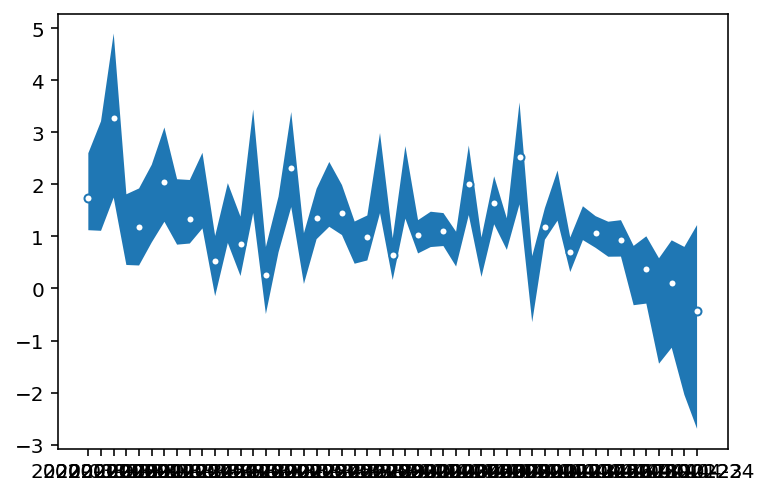

In [58]:
#  ax.plot(result['median'],
#             marker='o',
#             markersize=4,
#             markerfacecolor='w',
#             lw=1,
#             c=c,
#             markevery=2)
#     ax.fill_between(
#         result.index,
#         result['lower_90'].values,
#         result['upper_90'].values,
#         color=ci,
#         lw=0)

plt.plot(results['median'],
        marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            markevery=2)
plt.fill_between(results.index,results['lower_90'].values, results['upper_90'].values)
# plt.show()

In [45]:
plt.fill_between?

In [51]:
results.index('date')

TypeError: 'MultiIndex' object is not callable